import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

**Question 1:** \
Write Python code to read in the 100 aligned sequences, calculate mutual information between all pairs of columns, and plot these results in the upper triangle of an LxL (72x72) heat map.

In [64]:
# function that parses the file into a list of sequence names called sequence_names, and a numpy array called msa

def read_msa(msafile: str):

    # initialize empty list for the sequence names
    sequence_names = []
    
    # initialize empty list for the MSA
    msa_list = []
    
    # read the file
    with open(msafile, 'r') as file:
        for line in file:
            
            # append the sequence name to the list sequence_names
            sequence_names.append(line[0:line.find(' ')].strip())

            # append the sequence to the empty list msa
            sequence = line[line.find(' '):].strip()

            # records the length of the sequence
            L = len(sequence)

            # appending the sequence nucleotide by nucleotide
            split_sequence = [char for char in sequence]
            msa_list.append(split_sequence)

    # convert the list of sequences into a numpy array
    msa = np.array(msa_list)     

    # return the msa array
    return msa

In [65]:
# read in the 'rna.msa' file
msa = read_msa('rna.msa')

The <code>make_pmx</code> takes in an MSA formatted as an array. It iterates through every column and calculates the probability occurrence of each of the four nucleotides A, C, G, and T in that spot in the sequence (in that "column"). The function does this by counting the number of occurrences of each of these nucleotides, then dividing the counts by the total number of nucleotides in that column (in this case, 100, since we are working with 100 different sequences). 

The function returns an Lx4 array of these calculated probabilities. 

In [66]:
# function to calculate the individual probabilities of a nucleotide occurring for a spot in a sequence
# base pair encoding: A -> 0| C -> 1| G -> 2| T -> 3
def make_pmx(msa):
    # initialize list of probabilities
    pmx_list = []
    
    # iterate through every vertical column in the array
    for col in msa.T:
        total = msa.shape[0]

        # calculate the percentage of which each nucleotide comprmises every column of the array, or every
        # nucleotide space, in the order A | C | G | T
        A_fraction = np.count_nonzero(col == 'A') / total
        C_fraction = np.count_nonzero(col == 'C') / total
        G_fraction = np.count_nonzero(col == 'G') / total
        T_fraction = np.count_nonzero(col == 'T') / total

        column_probs = [A_fraction, C_fraction, G_fraction, T_fraction]

        # append the probabilities for that column to pmx_list
        pmx_list.append(column_probs)

    # convert the pmx_list into an array and then transpose it to get the correct dimensions
    pmx = np.transpose(np.array(pmx_list))
    return pmx

In [67]:
# calculate the probability matrix for the MSA given by the rna.msa file
pmx = make_pmx(msa)

The <code>make_pair_pmx</code> calculates the probability of a pair of bases occurring between two given columns. It is called within the <code>mutual_information</code> function written below. This function takes in two columns as input and creates a dictionary with all of the possible pairs of nucleotides as keys. The values of this dictionary are then updated with the probability of the occurence of that specific pairing between the two columns given. This dictionary is then returned.

In [68]:
# create a pair probability dictionary for the pair probabilities between two given columns 
def make_pair_pmx(col1, col2):
    keys = ['AT', 'AC', 'AA', 'AG', 'CT', 'CG', 'CC', 'GT', 'GG', 'TT', 'TA', 'CA', 'GA', 'TG', 'TC', 'GC']

    # create a temporary dictionary to store the occurrences of every base pairing
    base_pairings = dict.fromkeys(keys, 0)

    # create a dictionary to store the probabilities of every base pairing occurring
    pair_pmx = dict.fromkeys(keys)

    # iterates through every nucleotide pairing between two columns
    for nt in range(len(col1)):
        base_pair = str(col1[nt] + col2[nt])
        base_pairings[base_pair] +=1

    total = sum(base_pairings.values())
    
    pair_pmx['AT'] = base_pairings['AT'] / total
    pair_pmx['AC'] = base_pairings['AC'] / total
    pair_pmx['AG'] = base_pairings['AG'] / total
    pair_pmx['AA'] = base_pairings['AA'] / total

    pair_pmx['GT'] = base_pairings['GT'] / total
    pair_pmx['GC'] = base_pairings['GC'] / total
    pair_pmx['GG'] = base_pairings['GG'] / total
    pair_pmx['GA'] = base_pairings['GA'] / total

    pair_pmx['CT'] = base_pairings['CT'] / total
    pair_pmx['CC'] = base_pairings['CC'] / total
    pair_pmx['CA'] = base_pairings['CA'] / total
    pair_pmx['CG'] = base_pairings['CG'] / total

    pair_pmx['TT'] = base_pairings['TT'] / total
    pair_pmx['TA'] = base_pairings['TA'] / total
    pair_pmx['TC'] = base_pairings['TC'] / total
    pair_pmx['TG'] = base_pairings['TG'] / total
    
    return pair_pmx

The <code>mutual_information</code> function utilizes the equation below to calculate mutual information:
$$M_{ij} = \sum_{a,b} p_{ij} (a,b) log_2 \frac{p_{i,j}(a,b)}{p_i(a) p_j(b)} $$



In [69]:
# reminder: A -> 0| C -> 1| G -> 2| T -> 3
# calculate mutual information given an MSA and a pre-calculated probability matrix for that MSA 
def mutual_information(msa, pmx):
    # initialize array to store mutual information in
    m = np.zeros((msa.shape[1], msa.shape[1]))

    # iterate through every pair of columns in the MSA
    for i in range(msa.shape[1]):
        for j in range(i+1, msa.shape[1]):

            # define the pair of columns we are comparing 
            col1 = msa[:, i]
            col2 = msa[:, j]

            # call the pair_pmx function to create the pair probability matrix between the two columns
            pair_pmx = make_pair_pmx(col1, col2)           

            # obtain the unique list of base pairs that occur between the two columns
            base_pairs = []
            for base in range(len(col1)):    
                pair_key = f'{col1[base]}{col2[base]}'
                base_pairs.append(pair_key)
            unique_bps = list(set(base_pairs))

            # iterate through the unique list of base pairs that occur between the two columns and calculate mutual information
            base_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

            # intialize the sum to zero
            mutual = 0

            # iterate through every unique base pairing that occurs between the two columns and calculate the mutual 
            # information between those two nucleotides
            for pair in unique_bps:    
                nt = [char for char in pair]
                a = base_map[nt[0]]
                b = base_map[nt[1]]
                mutual += pair_pmx[pair] * np.log2(pair_pmx[pair] / (pmx[a][i] * pmx[b][j]))
            m[i,j] = mutual
    return m

Below, we plot the heat map for the matrix 'M', a 72x72 matrix containing the mutual information values for the 72 nucleotide MSA. The color bar on the right demonstrates how the darker the pixel, the higher the mutual information between the columns i and j, with i and j values being denoted on the x and y axis of the graph. 

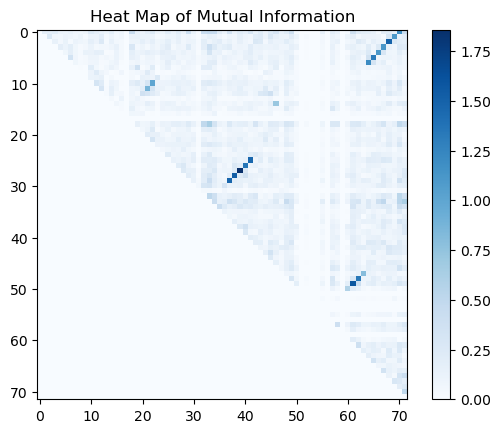

In [70]:
# heat map
M = mutual_information(msa, pmx)
plt.imshow(M, cmap='Blues', interpolation='nearest')
plt.title('Heat Map of Mutual Information')
plt.colorbar()
plt.show()

**Question 2:** \
Explain the main features you see in this plot. Do you see evidence for the tRNA cloverleaf? What are some other things or patterns you see?

**Answer:** In the upper half of this heatmap, we observe a large range of values for mutual information. The lighter the pixel/square, the lower the mutual information; the darker the pixel/square, the higher the mutual information between two columns of the MSA. If $M_{ij}$ is high, this indicates that the two columns are varying together, and therefore that the two columns are conserved across sequences. Essentially, if two columns are varying together, that means external factors acting on one column will also alter the other column. High mutual information indicates that those two nucleotides are part of a highly conserved region.

Looking at the coordinates of the pairs given, we can see that they correspond to the nucleotides in the tRNA strand that are basepairing to each other, i.e., forming a bond. If we look at the image of the tRNA strand that's given on the problem set, we can see that there are four such regions which correspond to the four diagonals that show up in the heat map. Thus, we can concludethat there is evidence for the tRNA cloverleaf. 

**Question 3:** \
Devise a "null hypothesis" and write code to produce an alignment with the same primary sequence conservation statistics as the original MSA, but where pairwise correlations have been randomized.

**Null Hypothesis:** There is no pairwise correlation. 

Using this randomized MSA, we can then find out what our base level of mutual information should be. Above this "base level" will be where our true signal for identifying highly conserved regions will be. 

In [34]:
# function to produce an alignment with the same primary sequence conservation statistics as the original MSA
# but where pairwise correlations have been randomized. Essentially, shuffle the columns of the MSA around.
def shuffle_msa(msa):
    for col in msa.T:
        np.random.shuffle(col)
    return msa

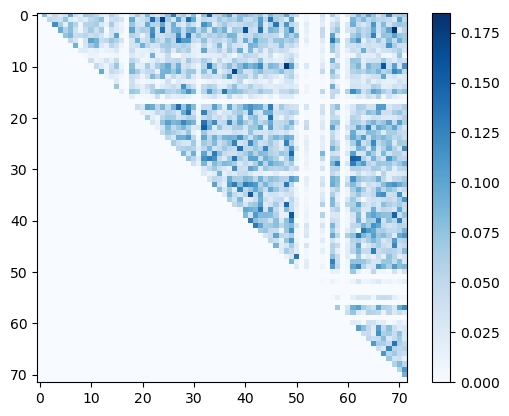

In [35]:
# create and plot the randomized MSA
randomized_msa = shuffle_msa(msa)
pmx_for_random = make_pmx(randomized_msa)

M_random = mutual_information(randomized_msa, pmx_for_random)
plt.imshow(M_random, cmap='Blues', interpolation='nearest')
plt.title('Mutual Information for Randomized MSA')
plt.colorbar()
plt.show()

**Question 4:** \
Produce a set of many randomized MSAs and calculate mutual information values from them. 

In [36]:
# produce a set of many randomized MSAs, calculate mutual information values from them, and then
# store the mutual information values in list

random_MI_list = []

# produce ten randomized MSAs
n = 10

for i in range(n):
    shuffled = shuffle_msa(msa)
    pmx_for_random = make_pmx(shuffled)
    randomized_MSA = mutual_information(shuffled, pmx_for_random)
    random_MI_list.append(randomized_MSA)

In [37]:
# function to extract just the upper right triangle of a mutual information matrix
def upper_right_triangle(matrix):
    info = []
    for i in range(matrix.shape[1]):
        for j in range(i+1, matrix.shape[1]):
            info.append(matrix[i][j])
    return info

In [38]:
# extract the upper right triangle of every matrix in the list of mutual information matrices for our randomized MSAs
upper_info = []

for matrix in random_MI_list:
    upper_info.extend(upper_right_triangle(matrix))

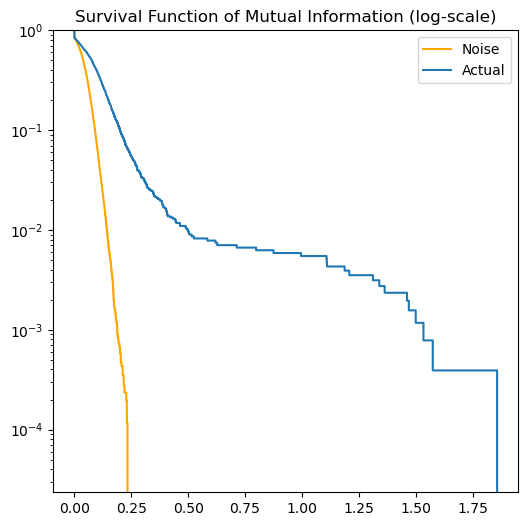

In [50]:
# extract the upper right triangle of the mutual information matrix for the original MSA
info = upper_right_triangle(M)

# set up line graph
fig, ax = plt.subplots(figsize=(6,6))
ax.ecdf(upper_info, complementary=True, color="orange", label = "Noise")
ax.ecdf(info, complementary=True, label = "Actual")
ax.set_yscale('log')
ax.set_title('Survival Function of Mutual Information (log-scale)')
ax.legend()

**Interpretation:** Randomizing the original MSA made mutual information go down, as seen in how the orange line displays much lower mutual information values than the blue line (original MSA). This is because if we are randomizing the sequence by shuffling columns around, we are breaking the original sequence column dependencies. Any original conserved patterns are no longer reflected in the shuffled/randomized alignment.

**Answer:** We will set our threshold t = 0.55. This is because mutual information values above 0.53 are not likely to occur, because the CDF appears to be flat on the graph of the actual MSA after around t = 0.55. Thus, as hypothesized in question 3, we can see that above this "base level" is where we are getting our real signal and not having interference from noise. These are the $M_{ij}$ values that are significant. 

**Question 5:** Extract a list of all the putative consensus base pairs that satisfy your threshold. Compare your list to the list of consensus base pairs expected for tRNA. How many of the expected base pairs are supported by your mutual information analysis? If you see support for other pairs, give a possible explanation for them.

In [55]:
# list of the consensus tRNA base pairs
bp_list = [  (0, 70),  (1, 69),  (2, 68),  (3, 67),  (4, 66), (5, 65), (6, 64),   # 7bp acceptor stem
             (9, 23), (10, 22), (11, 21), (12, 20),                               # 4bp D stem
            (25, 41), (26, 40), (27, 39), (28, 38), (29, 37),                     # 5bp anticodon stem
            (47, 63), (48, 62), (49, 61), (50, 60), (51, 59) ]                    # 5bp T stem;  

Below, we will extract the list of putative consensus base pairs that satisfy the threshold that we chose using our survival function plot.

In [58]:
# set the threshold
t = 0.55

# initialize 
putative_bp_list = []

# iterate through the upper right triangle of the mutual information matrix
for i in range(M.shape[1]):
    for j in range(i+1, M.shape[1]):
        
        # check to see if the mutual information at that base pair exceeds the threshold
        # if Mij > t, then we append that base pair (i,j) to the list of putative consensus base pairs
        if M[i][j] > t:
            bp = (i,j)
            putative_bp_list.append(bp)

In [60]:
print("List of putative base pairs:", putative_bp_list)

List of putative base pairs: [(0, 70), (1, 69), (2, 68), (3, 67), (4, 66), (5, 65), (6, 64), (10, 22), (11, 21), (14, 46), (18, 33), (25, 41), (26, 40), (27, 39), (28, 38), (29, 37), (33, 71), (47, 63), (48, 62), (49, 61), (50, 60)]


Our list of putative base pairs contains 3 base pairs that **are not** in the original list of the consensus tRNA base pairs: (14, 46), (18, 33), (33, 71). 

Our list of putative base pairs is also missing 3 base pairs that **are** in the original list of the consensus tRNA base pairs: (9, 23), (12, 20), (51, 59).

**Question 6:** Does the mutual information analysis support Wiggins' hypothesis that this conserved region encodes a tRNA?

**Answer:** The mutual information analysis does support Wiggins' hypothesis that this conserved region encodes a tRNA. As stated above, the list of putative base pairs extracted from running calculations on the rna.msa file was missing three of the base pairs that the list of consensus base pairs given to us; our produced list also had three additional base pairs compared to the list given to us. In other words, our mutual information analysis tells us that this is a conserved region. These 21 base pairs have high mutual information that is significant (above the threshold), indicating that covariation occurs between these nucleotide pairings and that they are evolutionarily conserved regions. These base pairs are the ones that present the darkest on the heat map of "M", which showed a pattern of four dark regions and evidenced a tRNA cloverleaf presence.

In [76]:
import watermark 
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

numpy     : 2.1.1
matplotlib: 3.9.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

